In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import pandas as pd
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from google.colab.patches import cv2_imshow
from PIL import Image

import datasets
from datasets import load_metric

from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Descomprimimos las imagenes. 

!unzip '/content/rice_images.zip'

Archive:  /content/rice_images.zip
replace rice_images/_Hispa/shape 393 .jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Funcion para crear un directorio nuevo.
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

# Funcion para cargar los datos y dividirlos en sets de entrenamiento
# validacion y test
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)

    return train_x, valid_x, test_x

In [5]:
np.random.seed(104)

create_dir("files")

# Path del file
dataset_path = '/content/rice_images'

# Cargamos los datos.
train_x, valid_x, test_x = load_data(dataset_path)

In [6]:
# Tamaño de los sets

print(f"train_x: {len(train_x)}, valid_x: {len(valid_x)}, test_x: {len(test_x)}")

train_x: 2685, valid_x: 335, test_x: 335


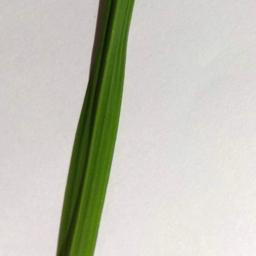

In [7]:
# Metodo para abrir diferentes tipos de imagenes.

im = Image.open(r'/content/rice_images/_Healthy/shape 1039 .jpg') 
im.show()

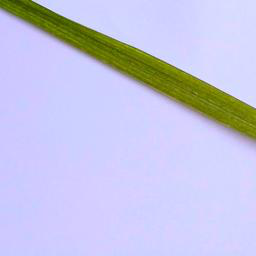

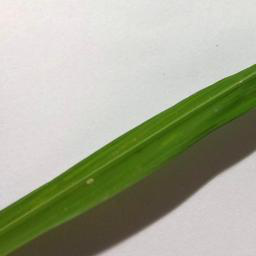

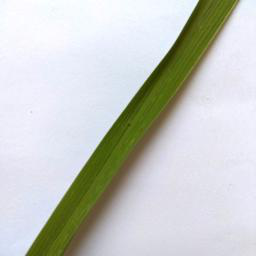

In [8]:
# Vemos tres imagenes de la clase healthy

healthy = ['/content/rice_images/_Healthy/shape 17 .jpg',
 '/content/rice_images/_Healthy/shape 1023 .jpg', '/content/rice_images/_Healthy/shape 1365 .jpg']

for i in healthy:
  ima = Image.open(i)
  ima.show()

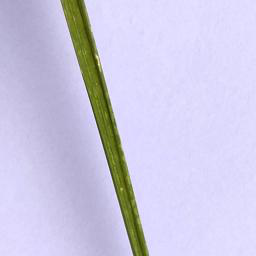

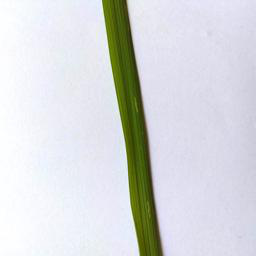

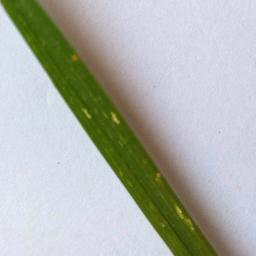

In [9]:
# Vemos tres imagenes de la clase hispa

hispa = ['/content/rice_images/_Hispa/shape 62 .jpg',
 '/content/rice_images/_Hispa/shape 210 .jpg',
 '/content/rice_images/_Hispa/shape 346 .jpg',
]

for i in hispa:
  ima = Image.open(i)
  ima.show()

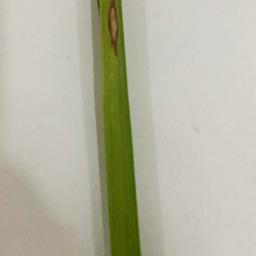

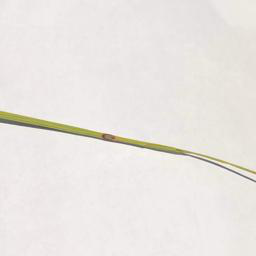

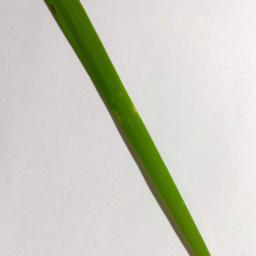

In [10]:
# Vemos tres imagenes de la clase leaf blast

leaf = ['/content/rice_images/_LeafBlast/shape 762 .jpg',
 '/content/rice_images/_LeafBlast/shape 611 .jpg',
 '/content/rice_images/_LeafBlast/shape 601 .jpg',
]

for i in leaf:
  ima = Image.open(i)
  ima.show()

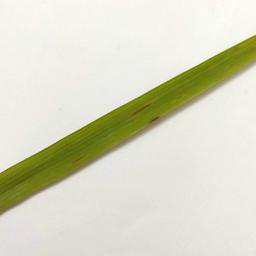

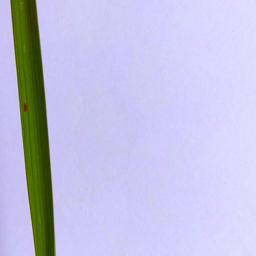

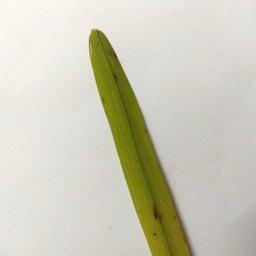

In [11]:
# Vemos tres imagenes de la clase brown_spot

brown = ['/content/rice_images/_BrownSpot/shape 293 .jpg',
 '/content/rice_images/_BrownSpot/shape 21 .jpg',
 '/content/rice_images/_BrownSpot/shape 161 .jpg',
]

for i in brown:
  ima = Image.open(i)
  ima.show()

In [12]:
# Modelo a utilizar

model_name_or_path = 'google/vit-base-patch16-224-in21k'

# Descargamos el feature extractor indicado para nuestro modelo para que 
# las transformaciones especificas que este necesita sean hechas en las imagenes

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [13]:
# Ejemplo del feature_extractor.

feature_extractor(im, return_tensors='pt')

{'pixel_values': tensor([[[[0.5843, 0.5843, 0.5843,  ..., 0.7098, 0.7098, 0.6941],
          [0.5765, 0.5765, 0.5765,  ..., 0.7176, 0.7098, 0.7098],
          [0.5765, 0.5765, 0.5765,  ..., 0.7176, 0.7176, 0.7176],
          ...,
          [0.8275, 0.8196, 0.8039,  ..., 0.9373, 0.9373, 0.9373],
          [0.8275, 0.8118, 0.7961,  ..., 0.9373, 0.9451, 0.9451],
          [0.8196, 0.8039, 0.7961,  ..., 0.9373, 0.9451, 0.9529]],

         [[0.5529, 0.5529, 0.5529,  ..., 0.6471, 0.6392, 0.6235],
          [0.5451, 0.5451, 0.5451,  ..., 0.6549, 0.6392, 0.6392],
          [0.5451, 0.5451, 0.5451,  ..., 0.6549, 0.6471, 0.6471],
          ...,
          [0.7804, 0.7725, 0.7569,  ..., 0.9059, 0.9059, 0.9059],
          [0.7804, 0.7647, 0.7490,  ..., 0.9059, 0.9137, 0.9137],
          [0.7725, 0.7569, 0.7490,  ..., 0.9059, 0.9137, 0.9216]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.6549, 0.6471, 0.6314],
          [0.5216, 0.5216, 0.5216,  ..., 0.6549, 0.6471, 0.6471],
          [0.5216, 0.5216

In [14]:
# Funcion para convertir nuestros datos en un Hugginface Dataset

def to_hugging(image_paths):
  hp = {}
  hp["class_names"] = ["_BrownSpot", "_Healthy", "_Hispa", "_LeafBlast"]

  dic_images = {}
  for i,j in enumerate(image_paths):
    dic_images[i] = {}
    dic_images[i]['image'] = Image.open(j)
    class_name = j.split("/")[-2]
    dic_images[i]['labels'] = hp["class_names"].index(class_name)
  
  return datasets.Dataset.from_dict({'image': [dic_images[i]['image'] for i in dic_images],
                                     'labels': [dic_images[i]['labels'] for i in dic_images]})

In [15]:
# Transformamos los datos en Hugginface Dataset
train_x_dataset = to_hugging(train_x)
test_x_dataset = to_hugging(test_x)
valid_x_dataset = to_hugging(valid_x)

In [16]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [17]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values.
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [18]:
# Aplicamos la formula anterior para dejar los datos preparados 
# para el modelo.
train_x_prepared = train_x_dataset.with_transform(transform)
test_x_prepared = test_x_dataset.with_transform(transform)
valid_x_prepared = valid_x_dataset.with_transform(transform)

## 2. Entrenamiento y validacion del modelo.

In [19]:
# Definimos una funcion para agrupar los batches de datos

import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [20]:
# Define la metrica de evaluacion.

# Esta sera utilizada para comparar la performance del modelo y sus predicciones.

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-20-aee0eea51140>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [21]:
# Cargamos el modelo pre-entrenado. Le añadimos el numero de Labels para que
# la capa de clasificacion tenga el numero correcto.

hp = {}
hp["class_names"] = ["_BrownSpot", "_Healthy", "_Hispa", "_LeafBlast"]

labels = hp['class_names']

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Hyperparametros con los que va a ser entrenado el modelo.

training_args = TrainingArguments(
  output_dir="./vit-base-beans2",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=1e-4/3,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [23]:
# Le damos todas las instancias al modelos para poder empezar a entrenarlo.

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_x_prepared,
    eval_dataset=test_x_prepared,
    tokenizer=feature_extractor,
)

In [24]:
# Entrenamos el modelo

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.827000,0.821827,0.728358
200,0.686400,0.719156,0.734328
300,0.498200,0.659198,0.779104
400,0.397800,0.663831,0.776119
500,0.304000,0.626932,0.788060
600,0.283500,0.622997,0.788060


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 775120115GF
  train_loss               =      0.5408
  train_runtime            =  0:01:53.57
  train_samples_per_second =      94.564
  train_steps_per_second   =       5.917


In [25]:
metrics = trainer.evaluate(valid_x_prepared)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.7493
  eval_loss               =     0.7273
  eval_runtime            = 0:00:02.04
  eval_samples_per_second =    163.993
  eval_steps_per_second   =      20.56


In [26]:
# Nuestro modelo inicial parece bastante prometedor con un 0.75 de accuracy.
# Vemos un claro overtitting en el entreamiento, este se da probablemente a la 
# cantidad reducida de datos que tenemos y la gran cantidad de parametros que tienen
# los modelos transformers.
# Se trendra que investigar como tunear los hyperparametros para mejorar la performance
# y reducir del overfitting de nuestros modelo.

In [27]:
test_preds_raw, test_labels , _ = trainer.predict(valid_x_prepared)
test_preds = np.argmax(test_preds_raw, axis=-1)

In [28]:
# Exploramos otras medicas con mas detalle. Cuando la variable target es multi-
# label o estas label estan desbalancedas, solo fijarno en el accuracy no puede 
# llevar a engaño

print(classification_report(test_labels, test_preds, digits=3))

              precision    recall  f1-score   support

           0      0.872     0.759     0.812        54
           1      0.758     0.806     0.781       144
           2      0.508     0.660     0.574        50
           3      0.871     0.701     0.777        87

    accuracy                          0.749       335
   macro avg      0.752     0.731     0.736       335
weighted avg      0.769     0.749     0.754       335



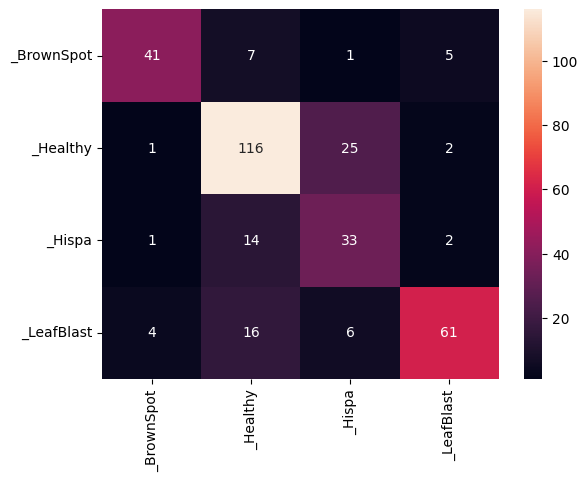

In [29]:
# Observamos en mas detalle de que se manera se equivoca nuestro modelo.

cm = confusion_matrix(test_labels, test_preds)
g = sns.heatmap(cm, annot=True, fmt='g')

g.set_xticklabels(hp['class_names'], rotation=90)
g.set_yticklabels(hp['class_names'], rotation=0)

plt.show()